**Construyendo AutoEncoders sobre MNIST con Learninspy**
============
<img style="display: inline;" src="../../docs/img/Learninspy-logo_grande2.png" width="300" />

### Dependencias

In [1]:
from learninspy.core.model import NetworkParameters, NeuralNetwork
from learninspy.core.autoencoder import AutoEncoder, StackedAutoencoder
from learninspy.core.optimization import OptimizerParameters
from learninspy.core.stops import criterion
from learninspy.utils.data import StandardScaler, LocalLabeledDataSet, split_data, label_data, load_mnist
from learninspy.utils.evaluation import RegressionMetrics
from learninspy.utils.plots import *
from learninspy.context import sc

import matplotlib.pyplot as plt
%matplotlib inline

2016-09-11 15:53:38,364 - learninspy.context - INFO - Contexto de Spark inicializado.
INFO:learninspy.context:Contexto de Spark inicializado.


### Carga de datos

In [2]:
print "Cargando base de datos de entrenamiento..."

t, train, valid = load_mnist()

# Tiro el primer dataset
t = None

train = LocalLabeledDataSet(train)
rows, cols = train.shape
print "Dimensiones: ", rows, " x ", cols

valid = LocalLabeledDataSet(valid)
rows, cols = valid.shape
print "Dimensiones: ", rows, " x ", cols

Cargando base de datos de entrenamiento...
Dimensiones:  10000  x  784
Dimensiones:  10000  x  784


<h2><center>## Modelado con un AutoEncoder ##</center></h2>

### Selección de parámetros para el modelo

In [3]:
units = [784, 100]
net_params = NetworkParameters(units_layers=units, activation=['ReLU', 'Sigmoid'], 
                                    strength_l2=1e-4, strength_l1=3e-5,
                                    classification=False)

### Selección de parámetros para la optimización

In [4]:
local_stops = [criterion['MaxIterations'](10),
               criterion['AchieveTolerance'](0.95, key='hits')]

global_stops = [criterion['MaxIterations'](20),
            criterion['AchieveTolerance'](0.95, key='hits')]

opt_params = OptimizerParameters(algorithm='Adadelta', 
                                 options={'step-rate': 1, 'decay': 0.995, 'momentum': 0.7, 'offset': 1e-8},
                                 stops=local_stops, merge_criter='w_avg')

### Fit de AE 

In [5]:
# Crear AutoEncoder simple
ae = AutoEncoder(net_params, dropout_in=0.0)
    
# Fit
hits_valid = ae.fit(train, valid, mini_batch=256, parallelism=4, valid_iters=10,
                     stops=global_stops, optimizer_params=opt_params, keep_best=False, reproducible=True)

2016-09-11 15:59:01,137 - learninspy.core.model - INFO - Epoca 1 realizada en 227.6379s. Hits en train: 0.29292081915. Hits en valid: 0.29889238523
2016-09-11 16:01:37,686 - learninspy.core.model - INFO - Epoca 2 realizada en 156.4948s.
2016-09-11 16:04:09,338 - learninspy.core.model - INFO - Epoca 3 realizada en 151.6096s.
2016-09-11 16:06:37,023 - learninspy.core.model - INFO - Epoca 4 realizada en 147.6406s.
2016-09-11 16:09:02,303 - learninspy.core.model - INFO - Epoca 5 realizada en 145.2371s.
2016-09-11 16:11:26,810 - learninspy.core.model - INFO - Epoca 6 realizada en 144.4637s.
2016-09-11 16:13:51,575 - learninspy.core.model - INFO - Epoca 7 realizada en 144.7236s.
2016-09-11 16:16:17,054 - learninspy.core.model - INFO - Epoca 8 realizada en 145.4294s.
2016-09-11 16:18:40,322 - learninspy.core.model - INFO - Epoca 9 realizada en 143.2234s.
2016-09-11 16:21:13,793 - learninspy.core.model - INFO - Epoca 10 realizada en 153.4255s.
2016-09-11 16:26:13,401 - learninspy.core.model - 

### Resultados visuales

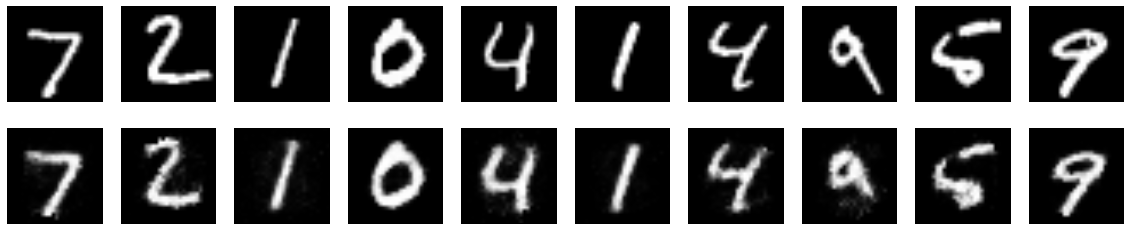

In [6]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(valid.data[i].features.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    predict = ae.predict(valid.data[i].features).matrix
    plt.imshow(predict.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from matplotlib.gridspec import GridSpec

n_units = 100 # (*)
n_input = 784 # (*)

plt.figure(figsize=(20, 20))
width, height = (10, 10) # (*)
gs = GridSpec(width, height)


w = ae.list_layers[0].weights.matrix # (*) np.array
# Reescala
w = w - np.mean(w)

x_max = []
for i in range(n_units):
    x_max.append(map(lambda j: w[i, j] / float(np.sqrt(sum([w_i_j ** 2 for w_i_j in w[i, ]]))),
                     range(n_input)))
    
for i in range(width):
    for j in range(height):
        x = x_max[i*(height) + j]
        
        ax = plt.subplot(gs[i, j])
        ax.imshow(np.array(x).reshape(28, 28))
        plt.gray()

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
plt.show()